In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SERSGenerator import SERSGenerator, pseudo_voigt

import seaborn as sns
sns.set()

# Generating dataset X from different pure Voigt spectra

In [2]:
np.random.seed(0)

In [3]:
N = 10000

Nw = 500
# Generate labels == distribution parameters
gamma = np.random.gamma(21, 0.5, size=N) # why gamma distribution? 
c = gamma + (Nw - 2 * gamma) * np.random.rand(N) # Prevent peak on the borders


# Generate variables == spectra
X = np.zeros((N, Nw))
w = np.arange(Nw)
for i in range(N):
    X[i,:] = pseudo_voigt(w, [c[i]], [gamma[i]], eta=[0])

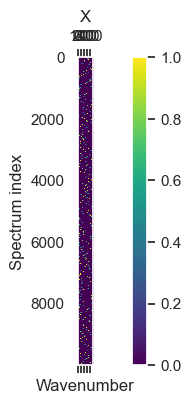

In [4]:
# Dataset Matrix
fig, ax = plt.subplots(1,1, figsize=(10,4))

mappable = ax.matshow(X, cmap='viridis')
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Spectrum index')
ax.set_title('X')
ax.grid(False)
plt.colorbar(mappable=mappable, ax=ax)
plt.show()

# PyTorch simple MLP

In [5]:
# Importing both packages
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self, in_size, hidden_units, out_size):
        super(SimpleMLP, self).__init__()
        
        self.net = nn.Sequential(nn.Linear(in_size, hidden_units).double(),
                                 nn.ReLU(),
                                 nn.Linear(hidden_units, hidden_units).double(),
                                 nn.ReLU(),
                                 nn.Linear(hidden_units, out_size).double())
        
    # We have also to define what is the forward of this module:
    def forward(self, x):
        out = self.net(x)
        return out

In [7]:
model = SimpleMLP(Nw, 128, 1) # Only focus on peak position
model

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, c, gamma, train=True):
        """Initializes a dataset containing spectra and labels."""
        super().__init__()
        self.train = train
        N = X.shape[0]

        if self.train:
            start = 0
            end = int(round(0.8*N))
        else:
            start = int(round(0.8*N))
            end = N
        
        self.X = X[start:end, :]
        self.c = c[start:end]
        self.gamma = gamma[start:end]

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.c)

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        item = X[index,:]
        label = c[index] #, gamma[index])

        return item, label

In [9]:
X_tensor = torch.from_numpy(X)
c_tensor = torch.from_numpy(c)
gamma_tensor = torch.from_numpy(gamma)

trainset = MyDataset(X_tensor, c_tensor, gamma_tensor, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=0)
testset = MyDataset(X_tensor, c_tensor, gamma_tensor, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=True, num_workers=0)

In [10]:
mse_loss = nn.MSELoss()

In [11]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
def train_conv(num_epochs):
    epochs_train_loss = []
    epochs_test_loss = []
    for i in range(num_epochs):
        
        if i % 1 == 0:
            with torch.no_grad():
                tmp_test_loss = []
                for inputs, targets in testloader:
                    outputs = model(inputs)
                    loss = mse_loss(outputs, targets)
                    tmp_test_loss.append(loss.detach())
                
                epochs_test_loss.append(torch.mean(torch.Tensor(tmp_test_loss)))
        
        
        tmp_loss = []
        for (x, y) in trainloader:
            outputs = model(x)
            loss = mse_loss(outputs, y)
            tmp_loss.append(loss.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epochs_train_loss.append(torch.mean(torch.Tensor(tmp_loss)))

        print('[Epoch {}/{}] '.format(i+1, num_epochs) +
              'loss: {:.4f} - '.format(epochs_train_loss[-1]) +
              'test_loss: {:.4f}'.format(epochs_test_loss[-1]))

    return epochs_train_loss, epochs_test_loss

In [13]:
train_loss, test_loss = train_conv(1000)

/Users/victor/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 1/1000] loss: 28163.0195 - test_loss: 81055.2812
[Epoch 2/1000] loss: 21017.7129 - test_loss: 21133.7441
[Epoch 3/1000] loss: 20744.4941 - test_loss: 20328.4785
[Epoch 4/1000] loss: 20131.0723 - test_loss: 20195.2910
[Epoch 5/1000] loss: 19929.9590 - test_loss: 19994.6914
[Epoch 6/1000] loss: 19974.2012 - test_loss: 20844.3008
[Epoch 7/1000] loss: 19875.9707 - test_loss: 20175.0371
[Epoch 8/1000] loss: 19958.1328 - test_loss: 20358.4805
[Epoch 9/1000] loss: 19669.5664 - test_loss: 19941.6855
[Epoch 10/1000] loss: 19782.7617 - test_loss: 21258.6211
[Epoch 11/1000] loss: 19865.0020 - test_loss: 20180.8789
[Epoch 12/1000] loss: 19702.9570 - test_loss: 19959.5957
[Epoch 13/1000] loss: 19713.0586 - test_loss: 20349.7383
[Epoch 14/1000] loss: 19546.8574 - test_loss: 20254.9121
[Epoch 15/1000] loss: 19498.6523 - test_loss: 19879.4961
[Epoch 16/1000] loss: 19485.5508 - test_loss: 19878.6133
[Epoch 17/1000] loss: 19505.0547 - test_loss: 19935.0312
[Epoch 18/1000] loss: 19356.5977 - test_

[Epoch 145/1000] loss: 19260.8535 - test_loss: 19839.9883
[Epoch 146/1000] loss: 19206.5352 - test_loss: 19782.5723
[Epoch 147/1000] loss: 19225.5957 - test_loss: 19795.1289
[Epoch 148/1000] loss: 19232.7012 - test_loss: 19762.3945
[Epoch 149/1000] loss: 19252.4609 - test_loss: 19799.5527
[Epoch 150/1000] loss: 19205.6523 - test_loss: 19785.6133
[Epoch 151/1000] loss: 19225.6094 - test_loss: 19781.6699
[Epoch 152/1000] loss: 19238.4746 - test_loss: 19814.8477
[Epoch 153/1000] loss: 19206.4219 - test_loss: 19775.8691
[Epoch 154/1000] loss: 19250.9961 - test_loss: 19945.3379
[Epoch 155/1000] loss: 19228.3594 - test_loss: 19781.0703
[Epoch 156/1000] loss: 19193.2500 - test_loss: 19756.3789
[Epoch 157/1000] loss: 19219.1680 - test_loss: 19767.4414
[Epoch 158/1000] loss: 19219.2520 - test_loss: 19803.6504
[Epoch 159/1000] loss: 19205.8242 - test_loss: 19757.6953
[Epoch 160/1000] loss: 19217.8945 - test_loss: 19768.0586
[Epoch 161/1000] loss: 19212.1309 - test_loss: 19756.2539
[Epoch 162/100

[Epoch 287/1000] loss: 19189.1387 - test_loss: 19796.6328
[Epoch 288/1000] loss: 19202.5781 - test_loss: 19765.6641
[Epoch 289/1000] loss: 19202.7793 - test_loss: 19858.6738
[Epoch 290/1000] loss: 19213.8398 - test_loss: 19758.1875
[Epoch 291/1000] loss: 19196.6270 - test_loss: 19778.7148
[Epoch 292/1000] loss: 19212.1289 - test_loss: 19768.5000
[Epoch 293/1000] loss: 19232.5938 - test_loss: 19774.3555
[Epoch 294/1000] loss: 19211.8281 - test_loss: 19805.8125
[Epoch 295/1000] loss: 19245.1035 - test_loss: 19762.9121
[Epoch 296/1000] loss: 19220.1133 - test_loss: 19796.3066
[Epoch 297/1000] loss: 19185.8379 - test_loss: 19764.0352
[Epoch 298/1000] loss: 19225.5117 - test_loss: 19840.7676
[Epoch 299/1000] loss: 19232.2910 - test_loss: 19772.4199
[Epoch 300/1000] loss: 19227.5586 - test_loss: 19923.0430
[Epoch 301/1000] loss: 19190.9453 - test_loss: 19759.7734
[Epoch 302/1000] loss: 19224.6133 - test_loss: 19759.9316
[Epoch 303/1000] loss: 19222.3633 - test_loss: 19899.8652
[Epoch 304/100

[Epoch 429/1000] loss: 19251.4102 - test_loss: 19851.7051
[Epoch 430/1000] loss: 19229.7168 - test_loss: 19756.0527
[Epoch 431/1000] loss: 19208.5000 - test_loss: 19788.5137
[Epoch 432/1000] loss: 19201.1660 - test_loss: 19802.5566
[Epoch 433/1000] loss: 19229.3086 - test_loss: 19761.4395
[Epoch 434/1000] loss: 19230.2051 - test_loss: 19842.9277
[Epoch 435/1000] loss: 19228.5625 - test_loss: 19823.7285
[Epoch 436/1000] loss: 19194.8125 - test_loss: 19762.2383
[Epoch 437/1000] loss: 19193.2969 - test_loss: 19832.3516
[Epoch 438/1000] loss: 19214.0645 - test_loss: 19895.3008
[Epoch 439/1000] loss: 19198.1250 - test_loss: 19785.5371
[Epoch 440/1000] loss: 19196.4102 - test_loss: 19795.3203
[Epoch 441/1000] loss: 19211.7227 - test_loss: 19781.7539
[Epoch 442/1000] loss: 19210.8906 - test_loss: 19762.5254
[Epoch 443/1000] loss: 19210.7129 - test_loss: 19756.9727
[Epoch 444/1000] loss: 19215.1602 - test_loss: 19785.6836
[Epoch 445/1000] loss: 19208.0488 - test_loss: 19899.8867
[Epoch 446/100

[Epoch 571/1000] loss: 19201.0547 - test_loss: 19815.0645
[Epoch 572/1000] loss: 19194.1797 - test_loss: 19756.1719
[Epoch 573/1000] loss: 19206.9180 - test_loss: 19788.4297
[Epoch 574/1000] loss: 19193.3086 - test_loss: 19795.5156
[Epoch 575/1000] loss: 19207.0352 - test_loss: 19766.2188
[Epoch 576/1000] loss: 19191.3066 - test_loss: 19765.5137
[Epoch 577/1000] loss: 19198.5645 - test_loss: 19756.1738
[Epoch 578/1000] loss: 19191.7773 - test_loss: 19856.1523
[Epoch 579/1000] loss: 19202.7559 - test_loss: 19756.9473
[Epoch 580/1000] loss: 19218.5508 - test_loss: 19917.8652
[Epoch 581/1000] loss: 19202.5527 - test_loss: 19761.3086
[Epoch 582/1000] loss: 19213.8438 - test_loss: 19800.8848
[Epoch 583/1000] loss: 19202.4473 - test_loss: 19775.8242
[Epoch 584/1000] loss: 19215.7617 - test_loss: 19756.8145
[Epoch 585/1000] loss: 19198.5215 - test_loss: 19756.1211
[Epoch 586/1000] loss: 19246.1680 - test_loss: 19767.5488
[Epoch 587/1000] loss: 19202.1406 - test_loss: 19758.2988
[Epoch 588/100

[Epoch 713/1000] loss: 19194.9258 - test_loss: 19767.6895
[Epoch 714/1000] loss: 19202.4648 - test_loss: 19816.9258
[Epoch 715/1000] loss: 19202.3086 - test_loss: 19756.6934
[Epoch 716/1000] loss: 19206.7383 - test_loss: 19757.4180
[Epoch 717/1000] loss: 19191.8008 - test_loss: 19756.1055
[Epoch 718/1000] loss: 19215.8574 - test_loss: 19756.4023
[Epoch 719/1000] loss: 19186.7520 - test_loss: 19786.8535
[Epoch 720/1000] loss: 19198.3027 - test_loss: 19757.7148
[Epoch 721/1000] loss: 19202.9609 - test_loss: 19757.2773
[Epoch 722/1000] loss: 19203.9531 - test_loss: 19761.4531
[Epoch 723/1000] loss: 19190.5547 - test_loss: 19823.6211
[Epoch 724/1000] loss: 19200.9551 - test_loss: 19759.5898
[Epoch 725/1000] loss: 19193.7617 - test_loss: 19757.5156
[Epoch 726/1000] loss: 19197.2539 - test_loss: 19756.1875
[Epoch 727/1000] loss: 19199.6133 - test_loss: 19814.6680
[Epoch 728/1000] loss: 19213.7324 - test_loss: 19802.6602
[Epoch 729/1000] loss: 19179.4688 - test_loss: 19775.8691
[Epoch 730/100

[Epoch 855/1000] loss: 19181.3770 - test_loss: 19758.0586
[Epoch 856/1000] loss: 19180.3789 - test_loss: 19756.2578
[Epoch 857/1000] loss: 19194.5918 - test_loss: 19757.5234
[Epoch 858/1000] loss: 19202.4414 - test_loss: 19757.6699
[Epoch 859/1000] loss: 19184.8164 - test_loss: 19761.8867
[Epoch 860/1000] loss: 19199.9102 - test_loss: 19757.1250
[Epoch 861/1000] loss: 19213.2539 - test_loss: 19756.1680
[Epoch 862/1000] loss: 19206.1211 - test_loss: 19758.0898
[Epoch 863/1000] loss: 19213.1133 - test_loss: 19799.8398
[Epoch 864/1000] loss: 19192.6934 - test_loss: 19807.1816
[Epoch 865/1000] loss: 19211.3887 - test_loss: 19803.5605
[Epoch 866/1000] loss: 19203.4648 - test_loss: 19757.7285
[Epoch 867/1000] loss: 19188.5586 - test_loss: 19760.4336
[Epoch 868/1000] loss: 19216.3340 - test_loss: 19816.1152
[Epoch 869/1000] loss: 19205.6191 - test_loss: 19756.5332
[Epoch 870/1000] loss: 19202.3184 - test_loss: 19786.6602
[Epoch 871/1000] loss: 19213.6719 - test_loss: 19766.1992
[Epoch 872/100

[Epoch 997/1000] loss: 19201.4551 - test_loss: 19773.7910
[Epoch 998/1000] loss: 19199.6289 - test_loss: 19797.2246
[Epoch 999/1000] loss: 19193.4727 - test_loss: 19771.6777
[Epoch 1000/1000] loss: 19196.8223 - test_loss: 19862.2656


Text(0, 0.5, 'Loss (MSE)')

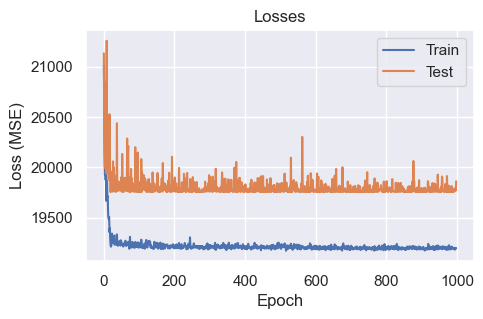

In [21]:
plt.figure(figsize=(5,3))
plt.title('Losses')
plt.plot(train_loss[1:], label='Train')
plt.plot(test_loss[1:], label='Test')
plt.grid(True)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')